# Thema 3 KI data-analyse

Idee is om eerst een basis functie op te stellen om inzicht te krijgen wat voor regulaties leiden tot betere/minder veel energiegebruik

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

dataset = np.asarray(((1, 2.5), 
           (2, 2.3),
           (3, 2.2),
           (4, 2),
           (5, 2.1),
           (6, 2.5),
           (7, 4.5),
           (8, 6),
           (9, 9.1),
           (10, 10.3),
           (11, 9.8),
           (12, 10),
           (13, 9.9),
           (14, 8.8),
           (15, 9),
           (16, 8.8),
           (17, 7.5),
           (18, 6.8),
           (19, 5),
           (20, 4),
           (21, 3.9),
           (22, 3.9),
           (23, 3),
           (24, 2.5),
           ))
X = dataset[:,0]
Y = dataset[:, 1]


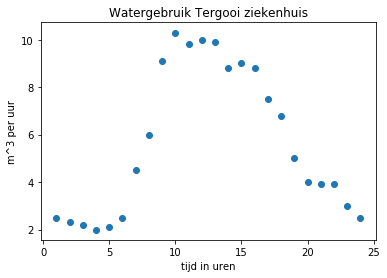

In [2]:
plt.scatter(X, Y)
plt.xlabel('tijd in uren')
plt.ylabel('m^3 per uur')
plt.title('Watergebruik Tergooi ziekenhuis')
plt.savefig('gebruikdots.png')

4.9991990796


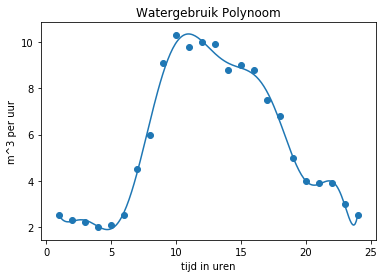

In [3]:
p = np.poly1d(np.polyfit(X, Y, 11))
xp = np.linspace(1, 24, 240)
plt.plot(xp, p(xp))
plt.scatter(X, Y)
print(p(0))
plt.xlabel('tijd in uren')
plt.ylabel('m^3 per uur')
plt.title('Watergebruik Polynoom')
plt.savefig('Combi-polynoom.png')

4.9991990796


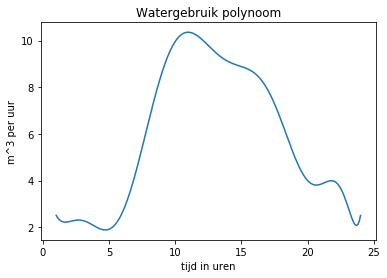

In [4]:
p = np.poly1d(np.polyfit(X, Y, 11))
xp = np.linspace(1, 24, 240)
plt.plot(xp, p(xp))
print(p(0))
plt.xlabel('tijd in uren')
plt.ylabel('m^3 per uur')
plt.title('Watergebruik polynoom')
plt.savefig('polynoom.png')

In [5]:
def calc_lin_usage(y1, y2, x):
    diff = y2 - y1
    return x*diff

calc_lin_usage(1,-1,0.2)
    

-0.4

In [6]:
def energycost(x):
    return 2**x + 2
energycost(10)

1026

In [7]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl

In [8]:
# New Antecedent/Consequent objects hold universe variables and membership
# functions
waterin = ctrl.Antecedent(np.arange(0, 15, 0.5), 'waterin')
volume = ctrl.Antecedent(np.arange(2, 100, 0.5), 'volume')
waterout = ctrl.Consequent(np.arange(0, 20, 0.5), 'waterout')


waterin['low'] = fuzz.trimf(waterin.universe, [0, 0, 4])
waterin['medium'] = fuzz.trimf(waterin.universe, [0, 4, 15])
waterin['high'] = fuzz.trimf(waterin.universe, [4, 15, 15])


volume['low'] = fuzz.trimf(volume.universe, [2, 2, 51])
volume['medium'] = fuzz.trimf(volume.universe, [2, 51, 100])
volume['high'] = fuzz.trimf(volume.universe, [51, 100, 100])

waterout['low'] = fuzz.trimf(waterout.universe, [0, 0, 10])
waterout['medium'] = fuzz.trimf(waterout.universe, [0, 10, 20])
waterout['high'] = fuzz.trimf(waterout.universe, [10, 20, 20])

# # Auto-membership function population is possible with .automf(3, 5, or 7)
# waterin.automf(3)
# waterout.automf(3)


/home/lucas/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


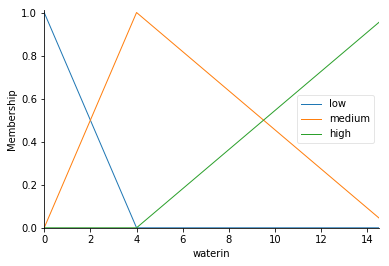

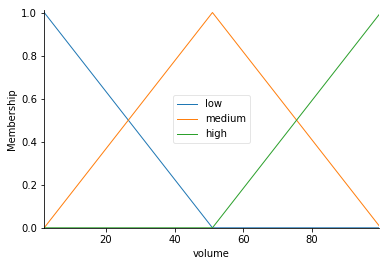

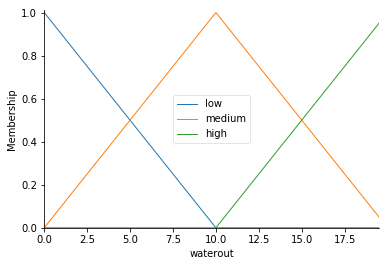

In [9]:
waterin.view()
volume.view()
waterout.view()

In [10]:
rule1 = ctrl.Rule(waterin['low'] & volume['low'], waterout['low'])
rule2 = ctrl.Rule(waterin['low'] & volume['medium'], waterout['low'])
rule3 = ctrl.Rule(waterin['low'] & volume['high'], waterout['medium'])
rule4 = ctrl.Rule(waterin['medium'] & volume['low'], waterout['low'])
rule5 = ctrl.Rule(waterin['medium'] & volume['medium'], waterout['medium'])
rule6 = ctrl.Rule(waterin['medium'] & volume['high'], waterout['medium'])
rule7 = ctrl.Rule(waterin['high'] & volume['low'], waterout['medium'])
rule8 = ctrl.Rule(waterin['high'] & volume['medium'], waterout['high'])
rule9 = ctrl.Rule(waterin['high'] & volume['high'], waterout['high'])

In [11]:
output_ctr = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5, rule6, rule7, rule8, rule9])

In [12]:
watermodel = ctrl.ControlSystemSimulation(output_ctr)

In [13]:
watermodel.input['waterin'] = 12
watermodel.input['volume'] = 90
watermodel.compute()

12.3586127111


/home/lucas/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


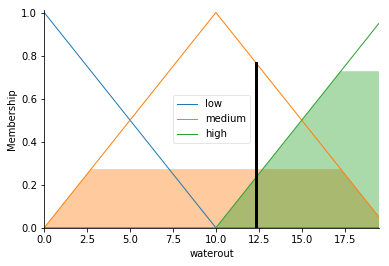

In [14]:
print(watermodel.output['waterout'])
waterout.view(sim=watermodel)

In [15]:
def calcfuzzvalue(watermodel, watin, vol):
    watermodel.input['waterin'] = watin
    watermodel.input['volume'] = vol
    watermodel.compute()
    return watermodel.output['waterout']

In [16]:
calcfuzzvalue(watermodel, 1, 2)

3.5000000000000004

In [27]:
def volume_fuzz(p, iters, steps, startval, watermodel):
    X = np.linspace(1, iters-1/steps, iters*steps)
    vol = startval
    vols = []
    energy = 0
    for i in X:
        waterin = p(i%24)/steps
        if vol < 2:
            fuzzval = calcfuzzvalue(watermodel, waterin, 2)
        else:
            fuzzval = calcfuzzvalue(watermodel, waterin, vol)
        vol += waterin
        fuzzval = fuzzval / steps
        energy += energycost(fuzzval)
        vol -= fuzzval
        vols.append(fuzzval * steps)
    plt.plot(X, vols)
    plt.xlabel('tijd in uren')
    plt.ylabel('m^3 per uur')
    plt.title('Waterafvoer snelheid')
    plt.savefig('fuzz_regulation.png')

In [28]:
def volume_stupid(p, iters, steps, startval):
    X = np.linspace(1, iters-1/steps, iters*steps)
    vol = startval
    vols = []
    energy = 0
    for i in X:
        pumpval = p(i%24)/steps
        vol += pumpval
        vol -= (vol - startval)
        vols.append(pumpval*steps)
        energy += energycost(pumpval)
    print(energy)
    plt.plot(X, vols)
    plt.xlabel('tijd in uren')
    plt.ylabel('m^3 per uur')
    plt.title('Waterafvoer snelheid')
    plt.savefig('regulation_stupid.png')

3507.81075691


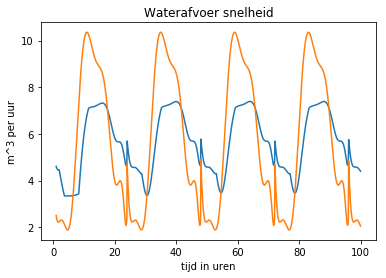

In [29]:
volume_fuzz(p, 100, 10, 7, watermodel)
volume_stupid(p, 100, 10, 7)